In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import plot_model, to_categorical


## Data Loading and Processing

In [2]:
labels = pd.read_csv("table_withlabels.csv")
foof = pd.read_csv("foof2features.csv")
beh = pd.read_csv("behaviorals.csv")

In [3]:
foof['IDs'] = foof['C1']
df = pd.merge(foof, labels[['label', 'IDs']], on='IDs', how='inner')
df = df.drop(columns=['C1'])
print(df['label'].value_counts())
df

Other Neurodevelopmental Disorders    492
ADHD-Inattentive Type                 388
ADHD-Combined Type                    376
Anxiety Disorders                     241
No Diagnosis Given                    203
Depressive Disorders                   85
Name: label, dtype: int64


,C2,C3,IDs,label
0,0.986272,1.825774,NDARAA075AMK,No Diagnosis Given
1,1.486650,1.888544,NDARAA112DMH,ADHD-Combined Type
2,1.593155,2.095749,NDARAA117NEJ,ADHD-Combined Type
3,0.703331,1.724831,NDARAA947ZG5,ADHD-Combined Type
4,0.918020,1.749441,NDARAA948VFH,ADHD-Combined Type
...,...,...,...,...
1780,0.168009,0.205704,NDARZN148PMN,Anxiety Disorders
1781,1.351549,1.996940,NDARZN277NR6,ADHD-Combined Type
1782,0.339229,1.050644,NDARZN610GTY,Other Neurodevelopmental Disorders
1783,0.781225,1.470061,NDARZN677EYE,ADHD-Inattentive Type


In [4]:
# add labels
pd.options.mode.chained_assignment = None

df.label[df.label == 'Other Neurodevelopmental Disorders'] = 1
df.label[df.label == 'ADHD-Inattentive Type'] = 2
df.label[df.label == 'ADHD-Combined Type'] = 3
df.label[df.label == 'Anxiety Disorders'] = 4
df.label[df.label == 'No Diagnosis Given'] = 5
df.label[df.label == 'Depressive Disorders'] = 6
df.label = df['label'].astype(int)
labels = ['Other Neurodevelopmental Disorders', 'ADHD-Inattentive Type', 'ADHD-Combined Type', 'Anxiety Disorders', 'No Diagnosis Given', 'Depressive Disorders']

In [5]:
train_df, test_df = train_test_split(df, test_size=0.33)
train_labels, test_labels = train_df['label'], test_df['label']
train_df.shape
print(test_labels.shape)
print(train_labels.shape)
train_features = train_df[train_df.columns.difference(['IDs', 'label'])]
test_features = test_df[test_df.columns.difference(['IDs', 'label'])]
print(test_features.shape)
print(train_features.shape)

(590,)
(1195,)
(590, 2)
(1195, 2)


## Dealing with imbalance

In [6]:
oversample = SMOTE()
train_features_oversampled, train_labels_oversampled = oversample.fit_resample(train_features, train_labels)
print(train_features_oversampled.shape)
print(train_labels_oversampled.shape)

(2016, 2)
(2016,)


In [7]:
# scaling the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features_oversampled = scaler.fit_transform(train_features_oversampled) 
test_features = scaler.transform(test_features)

train_features_oversampled = np.clip(train_features_oversampled, -5, 5)
test_features = np.clip(test_features, -5, 5)

In [8]:
print(train_features_oversampled.shape)
print(train_labels_oversampled.shape)

(2016, 2)
(2016,)


## Linear Models

### SVC

In [9]:
from sklearn import svm

clf = svm.SVC(kernel='linear', verbose=True)
clf.fit(train_features_oversampled, train_labels_oversampled)

predicted_labels_svc = clf.predict(test_features)

[LibSVM].
*
optimization finished, #iter = 1212
obj = -656.629097, rho = -0.231992
nSV = 659, nBSV = 655
*
optimization finished, #iter = 618
obj = -645.787674, rho = 0.137687
nSV = 647, nBSV = 644
.
*
optimization finished, #iter = 1214
obj = -625.699617, rho = -0.216676
nSV = 627, nBSV = 623
.
*.
*
optimization finished, #iter = 1415
obj = -644.986837, rho = 0.115791
nSV = 647, nBSV = 644
.
*.*
optimization finished, #iter = 1847
obj = -493.919772, rho = -0.183482
nSV = 497, nBSV = 493
*.*
optimization finished, #iter = 700
obj = -623.919710, rho = 0.010321
nSV = 626, nBSV = 622
.
*
optimization finished, #iter = 1057
obj = -644.393037, rho = -0.454027
nSV = 646, nBSV = 643
.
*.*
optimization finished, #iter = 1436
obj = -620.737582, rho = 0.022334
nSV = 622, nBSV = 619
.
*
optimization finished, #iter = 766
obj = -519.430315, rho = -0.285149
nSV = 521, nBSV = 518
.
*
optimization finished, #iter = 934
obj = -589.191701, rho = -0.167510
nSV = 591, nBSV = 588
.*
optimization finished,

Accuracy: 0.19830508474576272
Precision: 0.19830508474576272
Recall: 0.19830508474576272
F1 score: 0.19830508474576272


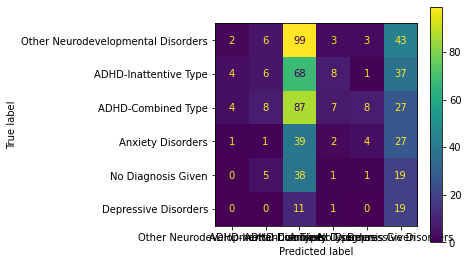

In [10]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate(y_test, y_pred, show_cm=True):
    
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("Precision:", metrics.precision_score(y_test, y_pred, average='micro'))
    print("Recall:", metrics.recall_score(y_test, y_pred, average='micro'))
#     print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred, multi_class='ovo',))
    print("F1 score:", metrics.f1_score(y_test, y_pred, average='micro'))
#     print("Brier Score:", metrics.brier_score_loss(y_test, y_pred)) # only for binary classification

    if show_cm:
        cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        plt.tight_layout()
        plt.show()

evaluate(test_labels, predicted_labels_svc)

### OneVsRestClassifier
The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes.

In [11]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

clf = OneVsRestClassifier(LinearSVC(random_state=0, max_iter=2000, verbose=True))

clf.fit(train_features_oversampled, train_labels_oversampled)
predicted_labels_ovr = clf.predict(test_features)

[LibLinear]........................................................*............................................
optimization finished, #iter = 1001
Objective value = -1115.584244
nSV = 2016
[LibLinear]...............................................................
optimization finished, #iter = 633
Objective value = -1119.673822
nSV = 2016
[LibLinear]...................................................................................*
optimization finished, #iter = 835
Objective value = -1098.195886
nSV = 1996
[LibLinear]........................................................................
optimization finished, #iter = 729
Objective value = -1116.220329
nSV = 2016
[LibLinear].............................................*
optimization finished, #iter = 452
Objective value = -1103.191790
nSV = 2005
[LibLinear]...............................................................................*...........*
optimization finished, #iter = 908
Objective value = -1025.720258
nSV = 1974


Accuracy: 0.17288135593220338
Precision: 0.17288135593220338
Recall: 0.17288135593220338
F1 score: 0.17288135593220338


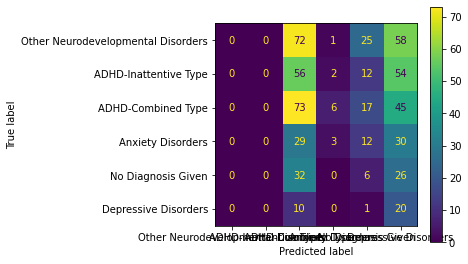

In [12]:
evaluate(test_labels, predicted_labels_ovr)

### OneVsOneClassifier
OneVsOneClassifier constructs one classifier per pair of classes. At prediction time, the class which received the most votes is selected. In the event of a tie (among two classes with an equal number of votes), it selects the class with the highest aggregate classification confidence by summing over the pair-wise classification confidence levels computed by the underlying binary classifiers.



In [13]:
from sklearn.multiclass import OneVsOneClassifier

clf = OneVsOneClassifier(LinearSVC(random_state=0, max_iter = 10000, verbose=True))

clf.fit(train_features_oversampled, train_labels_oversampled)
predicted_labels_ovo = clf.predict(test_features)

[LibLinear]...................................................
optimization finished, #iter = 517
Objective value = -669.776728
nSV = 672
[LibLinear]...........................................................................
optimization finished, #iter = 754
Objective value = -666.270530
nSV = 672
[LibLinear]......................................................
optimization finished, #iter = 546
Objective value = -659.421849
nSV = 672
[LibLinear].........................................*...............................................
optimization finished, #iter = 883
Objective value = -667.044254
nSV = 672
[LibLinear].....................................................*........................*
optimization finished, #iter = 771
Objective value = -571.636750
nSV = 663
[LibLinear].............................................................................
optimization finished, #iter = 775
Objective value = -657.247209
nSV = 672
[LibLinear]..........................................

Accuracy: 0.17288135593220338
Precision: 0.17288135593220338
Recall: 0.17288135593220338
F1 score: 0.17288135593220338


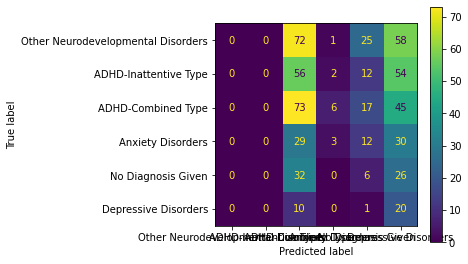

In [14]:
evaluate(test_labels, predicted_labels_ovr)

### Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5, random_state=0, verbose=True)
clf.fit(train_features_oversampled, train_labels_oversampled)
predicted_labels_rf = clf.predict(test_features)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy: 0.15423728813559323
Precision: 0.15423728813559323
Recall: 0.15423728813559323
F1 score: 0.15423728813559323


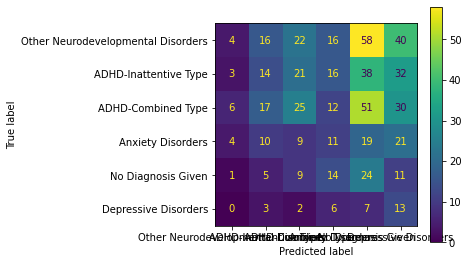

In [16]:
evaluate(test_labels, predicted_labels_rf)

### MLP


In [17]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=300, verbose=True)
clf.fit(train_features_oversampled, train_labels_oversampled)
predicted_labels_mlp = clf.predict(test_features)

Iteration 1, loss = 1.80926885
Iteration 2, loss = 1.77396499
Iteration 3, loss = 1.75384653
Iteration 4, loss = 1.74401326
Iteration 5, loss = 1.73841826
Iteration 6, loss = 1.73468545
Iteration 7, loss = 1.73161687
Iteration 8, loss = 1.72914684
Iteration 9, loss = 1.72652132
Iteration 10, loss = 1.72478690
Iteration 11, loss = 1.72355691
Iteration 12, loss = 1.72141762
Iteration 13, loss = 1.72016105
Iteration 14, loss = 1.71862125
Iteration 15, loss = 1.71716231
Iteration 16, loss = 1.71598294
Iteration 17, loss = 1.71451413
Iteration 18, loss = 1.71375756
Iteration 19, loss = 1.71269797
Iteration 20, loss = 1.71200539
Iteration 21, loss = 1.71078707
Iteration 22, loss = 1.70992614
Iteration 23, loss = 1.70947796
Iteration 24, loss = 1.70967652
Iteration 25, loss = 1.70840127
Iteration 26, loss = 1.70844249
Iteration 27, loss = 1.70715255
Iteration 28, loss = 1.70637525
Iteration 29, loss = 1.70664060
Iteration 30, loss = 1.70597002
Iteration 31, loss = 1.70544346
Iteration 32, los

/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.14576271186440679
Precision: 0.14576271186440679
Recall: 0.14576271186440679
F1 score: 0.14576271186440679


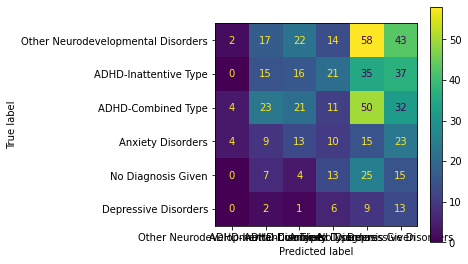

In [18]:
evaluate(test_labels, predicted_labels_mlp)